### Maps of wind speed and SLP in the Beaufort Sea region 

#### Author: Jonathan Rheinlænder*
#### Date: Jun. 02 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [5]:
#! /usr/bin/env python
%matplotlib inline
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
from pynextsim.projection_info import ProjectionInfo
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes


In [6]:
def prepare_grid(ds):
    extent = [-110, 200, 67, 90]
    proj = ProjectionInfo() # default nextsim projection

    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent,
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,)

    return grid

def make_figure(width, height, nrow, ncol):
    ar = 0.9  # initial aspect ratio for first trial
    wi = width    # width in inches
    hi = height  # height in inches

    fig = plt.figure(figsize=(wi,hi))
    plt.subplots_adjust(hspace=0.01, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 


In [7]:
# create dictionary for plotting different variables
_PLOT_INFO =dict(
    psl = ('Sea Level Pressure [hPa]', 'slp_beaufort','rainbow', [1010,1052,2], 'both'),
)


# Plot winds and mean SLP in the Beaufort Sea

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/breakup-event-2013/figs/breakup-paper/wspeed_slp_beaufort_20130219-20130227_wrf10.png


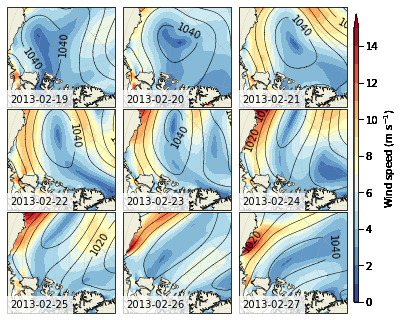

In [14]:
rootdir = '/home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
outdir =  '/home/rheinlender/shared-simstore-ns9829k/home/rheinlender/breakup-event-2013/figs/breakup-paper/'

# Open Mooring
expts = ["expt_01_wrf10/outputs/", "expt_02_wrf20/outputs/","expt_03_wrf40/outputs/","expt_04_wrf80/outputs/"]
expts_names = ["wrf10", "wrf20","wrf40","wrf80"]

files = [os.path.join(rootdir, f, 'Moorings.nc') for f in expts]

k=0 # which expt?

ds = xr.open_dataset(files[k])
grid = prepare_grid(ds)

vname = ['wspeed', 'psl']
ds['psl'] = ds['psl']*1e-2

# subset variable
start_date = dt.datetime(2013,2,19)
end_date =  start_date + dt.timedelta(days=8)

clim = [0,15,1] # for wind speed
clim2 = [1000,1060,5] # for sea level pressure

cmap = 'RdYlBu_r'
cb_extend = 'max'
clabel = 'Wind speed (m s$^{-1}$)'

clevs = np.arange(clim[0], clim[1]+clim[2], clim[2])
clevs2 = np.arange(clim2[0], clim2[1]+clim2[2], clim2[2])

levels = [1000, 1020, 1040, 1060]    
    
fig, gs = make_figure(6,5, 3, 3); # make the figure

# loop over dates
for i in range((end_date-start_date).days + 1):
    
    dto = start_date + dt.timedelta(days=i) 
    dto = dt.datetime.strftime(dto,'%Y-%m-%d')
        
    # prepare axes
    ax = plt.subplot(gs[i], projection=grid['proj'].crs, extent=grid['extent'])
    ax.add_feature(cartopy.feature.LAND, zorder=1, alpha=1)
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2, linewidth=0.5, alpha=0.5, linestyle="--")
    
    # add date inside subplots
    ax.text(0.03,0.05, dto, horizontalalignment='left',
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None', alpha=0.75))
     
    for var in vname:
        #print("Extracting", var, "for", dto) 
        arr = ds[var].sel(time=dto)
        arr = arr.mean(dim='time',skipna=False) # create daily fields (from 3h averages)
        
        if var=='wspeed':
            # Filled contours
            cs = ax.contourf(arr, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']], 
                        levels=clevs, cmap=cmap, extend=cb_extend)
                
        elif var=='psl':
            # add contour lines
            cl = ax.contour(arr, clevs2, origin='lower', extent=[*grid['x_extent'], *grid['y_extent']],
                            colors='k', linewidths=0.5) 

            ax.clabel(cl,levels, fmt='%2.0f', colors='k', fontsize=10)


    # add colorbar
    fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.9, wspace=0.02, hspace=0.02)
    cb_ax = fig.add_axes([0.91, 0.13, 0.01, 0.8]) # add axes for colorbar
    cbar = fig.colorbar(cs, cax=cb_ax, label=clabel)     

    
# save figure
figname = os.path.join(outdir,
      '%s_%s-%s_%s' % ('wspeed_slp_beaufort', start_date.strftime('%Y%m%d'), end_date.strftime('%Y%m%d'), expts_names[k]))
figname = figname + '.png'
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')    

# Plot winds as anomalies from WRF10

saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/wspeed_anom_beaufort_20130218-20130228_wrf20.png
saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/wspeed_anom_beaufort_20130218-20130228_wrf40.png
saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/wspeed_anom_beaufort_20130218-20130228_wrf80.png
Frozen({'time': 232, 'nv': 2, 'y': 647, 'x': 719})
saving... /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/wspeed_anom_beaufort_20130218-20130228_era5-30km.png


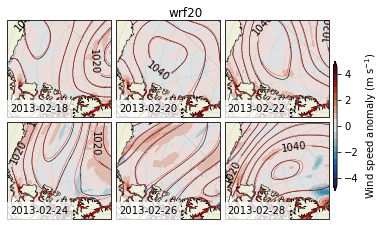

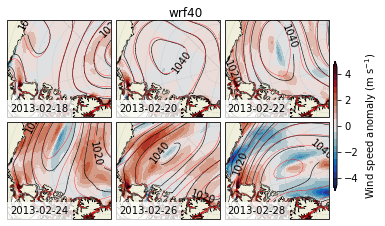

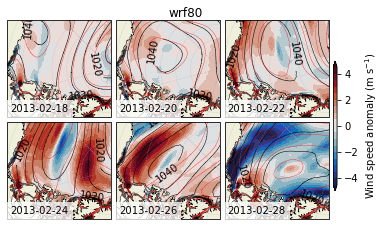

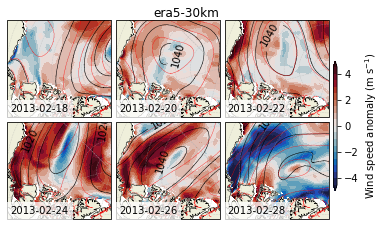

In [16]:
rootdir = '/home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
outdir =  '/home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/'

# Open Mooring
expts = ["expt_01_wrf10/outputs/", 
         "expt_02_wrf20/outputs/",
         "expt_03_wrf40/outputs/",
         "expt_04_wrf80/outputs/",
         "expt_00_era5/outputs/",
         "expt_01_smoothed80/outputs/"]
expts_names = ["wrf10", "wrf20","wrf40","wrf80", "era5-30km", "wrf10_coarse80"]

files = [os.path.join(rootdir, f, 'Moorings.nc') for f in expts]

wrf10 = xr.open_dataset(files[0])

#k=2 # which expt?
for k in range(1,5):

    ds = xr.open_dataset(files[k])
    grid = prepare_grid(ds)

    if k==4:
        yl=wrf10.dims['y']
        xl=wrf10.dims['x']
        ds = ds.sel(x=slice(0,xl), y=slice(0,yl))
        print(ds.dims)


    if k==0:
        vname = ['wspeed', 'psl']
        ds['psl'] = ds['psl']*1e-2

        cmap = 'RdYlBu_r'
        cb_extend = 'max'
        clabel = 'Wind speed (m s$^{-1}$)'
        clim = [0,15,1] # for wind speed
        clim2 = [1000,1060,5] # for sea level pressure
        clevs = np.arange(clim[0], clim[1]+clim[2], clim[2])
        clevs2 = np.arange(clim2[0], clim2[1]+clim2[2], clim2[2])
        levels = [1000, 1020, 1040, 1060]
        ticks = np.arange(0,clim[1],2)

    else:
        clim = [-4.5, 4.5,0.5]
        slp_levs = np.arange(1000,1060+5,5) # for sea level pressure
        cmap = cmocean.cm.balance
        cb_extend = 'both'
        clabel = 'Wind speed anomaly (m s$^{-1}$)'
        clevs = np.arange(clim[0], clim[1]+clim[2], clim[2])
        ticks = [-4, -2, 0, 2 ,4]

    # subset variable
    start_date = dt.datetime(2013,2,18)
    end_date= dt.datetime(2013,3,2)
    delta=2
    dates = [start_date + dt.timedelta(days=x) for x in range(0, int ((end_date - start_date).days),delta) ]


    fig, gs = make_figure(5,3, 2, 3); # make the figure

    # loop over dates
    for i, dto in enumerate(dates):

        dto = dt.datetime.strftime(dto,'%Y-%m-%d')

        # prepare axes
        ax = plt.subplot(gs[i], projection=grid['proj'].crs, extent=grid['extent'])
        ax.add_feature(cartopy.feature.LAND, zorder=1, alpha=1)
        ax.coastlines(resolution='50m', linewidth=0.5)
        ax.set_aspect(1)
        ax.gridlines(zorder=2, linewidth=0.5, alpha=0.5, linestyle="--")

        # add date inside subplots
        ax.text(0.03,0.05, dto, horizontalalignment='left',
            transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None', alpha=0.75))

        if k==0:        
            for var in vname:
                print("Extracting", var, "for", dto) 
                arr = ds[var].sel(time=dto)
                arr = arr.mean(dim='time',skipna=False) # create daily fields (from 3h averages)

                if var=='wspeed':
                    # Filled contours
                    cs = ax.contourf(arr, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']], 
                                levels=clevs, cmap=cmap, extend=cb_extend)

                elif var=='psl':
                    # add contour lines
                    cl = ax.contour(arr, clevs2, origin='lower', extent=[*grid['x_extent'], *grid['y_extent']],
                                    colors='k', linewidths=0.5) 

                    ax.clabel(cl,levels, fmt='%2.0f', colors='k', fontsize=10)

        else:
            # calculate anomaly 
            wanom = (ds['wspeed'].sel(time=dto) - wrf10['wspeed'].sel(time=dto) )
            wanom = wanom.mean(dim='time',skipna=False) # create daily fields (from 3h averages)   

            slp = (ds['psl'].sel(time=dto))*1e-2 # in hPa
            slp = slp.mean(dim='time',skipna=False)
            
            slp_wrf10 = (wrf10['psl'].sel(time=dto))*1e-2 # in hPa
            slp_wrf10 = slp_wrf10.mean(dim='time',skipna=False)

            # Filled contours
            cs = ax.contourf(wanom, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']], 
                                levels=clevs, cmap=cmap, extend=cb_extend)
            # add contour lines
            #cl = ax.contour(wanom, cs.levels[::2], origin='lower', extent=[*grid['x_extent'], *grid['y_extent']],
            #                    colors='k', linewidths=0.3, alpha=0.5)

            # add SLP contours
            cl = ax.contour(slp, slp_levs, origin='lower', extent=[*grid['x_extent'],*grid['y_extent']],
                            colors='k', linewidths=0.5, alpha=1)
            cl2 = ax.contour(slp_wrf10, slp_levs, origin='lower', extent=[*grid['x_extent'],*grid['y_extent']],
                            colors='r',linestyles='solid', linewidths=0.3, alpha=1)
            ax.clabel(cl,[1000, 1020, 1040, 1060], fmt='%2.0f', colors='k', fontsize=10)



    fig.subplots_adjust(bottom=0., top=0.92, left=0., right=0.90, wspace=0.02, hspace=0.05)
    fig.suptitle(expts_names[k])
    cb_ax = fig.add_axes([0.91, 0.13, 0.01, 0.6]) # add axes for colorbar
    cbar = fig.colorbar(cs, cax=cb_ax, label=clabel, ticks=ticks) 

    # save figure
    figname = os.path.join(outdir,
                           '%s_%s-%s_%s' % ('wspeed_anom_beaufort', dates[0].strftime('%Y%m%d'),  dates[-1].strftime('%Y%m%d'), expts_names[k]))
    figname = figname + '.png'
    print("saving...", figname)
    fig.savefig(figname, dpi=300, bbox_inches='tight')    

# Plot timeseries of mean wind speeds in the Beaufort Sea

In [ ]:

ds0 = xr.open_dataset(files[0])
# create mask
x0=0; x1=260; y0=150; y1=410

mask_ocean = 1 * np.ones((ds0.dims['y'], ds0.dims['x'])) * np.isfinite(ds0.sic.isel(time=0))  
mask_land = np.zeros((ds0.dims['y'], ds0.dims['x'])) * np.isnan(ds0.sic.isel(time=0))  
mask_array = mask_ocean + mask_land

mask = mask_array.where((mask_array.x >= x0) & (mask_array.x <= x1) 
                         & (mask_array.y >= y0) & (mask_array.y <= y1))

time = ds0['time'].time.values.astype('datetime64[ms]').astype('O')

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(8,3)) 

for i, file in enumerate(files):
    ds = xr.open_dataset(file)
    print("opening", file)
    
    wspeed_avg = ds['wspeed'].where(mask==1).mean(dim=('x', 'y'))
    wspeed_max = ds['wspeed'].where(mask==1).max(dim=('x', 'y'))
    wspeed_med = ds['wspeed'].where(mask==1).median(dim=('x', 'y'))

    color = next(ax._get_lines.prop_cycler)['color']
    l = ax.plot(time, wspeed_avg, label=expts_names[i], color=color)
#    l2 = ax.plot(time, wspeed_max, linestyle='--', color=color)
    l2 = ax.plot(time, wspeed_med, linestyle='--', color=color)

ax.legend(loc=2)    

days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.set_ylabel('Mean wind speed [m s$^{-1}$]')
ax.grid(linestyle='--', alpha=0.4)
    
# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'ave+median_wspeed_beaufort','all_expts', '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=150, bbox_inches='tight')

# Plot timeseries of max winds along the transect in the Beaufort Sea

In [ ]:

def get_transect(start_time, end_time, xpoint, ypoint):

    time_slice = slice(start_time, end_time)
    x_slice = xpoint[0]
    y_slice = slice(ypoint[0], ypoint[1])

    transect = ds[vname].sel(time=time_slice, x=x_slice, y=y_slice)

    # make array of datetime objects
    vtimes = transect.time.values.astype('datetime64[ms]').astype('O')

    # Specify y values for transect
    length = y_slice.stop - y_slice.start
    yvals = np.linspace(y_slice.start, y_slice.stop, length) 

    print(yvals.shape, vtimes.shape, transect.shape)

    return yvals, vtimes, transect

# Create slice variables subset domain
vname='wspeed'
start_time = '2013-02-11'
end_time = '2013-03-13'
xpoint = (100, 100)
ypoint = (180, 450)

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(8,3)) 

for i, file in enumerate(files):
    ds = xr.open_dataset(file)
    print("opening", file)
    
    yvals, vtimes, WStrans = get_transect(start_time, end_time, xpoint, ypoint)


    wspeed_avg = WStrans.mean(dim=('y')) # mean along transect
    wspeed_max = WStrans.max(dim=('y')) # max along transect
    wspeed_med = WStrans.median(dim=('y')) # median along transect
    
    color = next(ax._get_lines.prop_cycler)['color']
    l = ax.plot(vtimes, wspeed_max, label=expts_names[i], color=color)
   # l2 = ax.plot(vtimes, wspeed_max, linestyle='--', color=color)

#ax.legend(loc=2)    

days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.set_ylabel('Max wind speed [m s$^{-1}$]')
ax.grid(linestyle='--', alpha=0.4)
ax.set_xlim(vtimes[0], vtimes[-1])
fig.subplots_adjust(bottom=0.18, top=0.90, left=0.08, right=0.9, wspace=0.01, hspace=0.01)
plt.show()
# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s%s' % (outpath_plots, 'max_wspeed_beaufort_transect','all_expts', '.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# PLOT HISTOGRAMS OF WIND SPEED

In [ ]:

wrf10 = xr.open_dataset(files[0])
wrf40 = xr.open_dataset(files[2])
wrf80 = xr.open_dataset(files[3])

# pick dates to plot
t1 = '2013-02-19' # start of simulation
t2 = '2013-03-01' # end of simulation

ws10 = wrf10['wspeed'].where(mask==1).sel(time=slice(t1,t2)).mean(dim='time') 
ws40 = wrf40['wspeed'].where(mask==1).sel(time=slice(t1,t2)).mean(dim='time') 
ws80 = wrf80['wspeed'].where(mask==1).sel(time=slice(t1,t2)).mean(dim='time') 

kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=40, ec="k")

fig, ax = plt.subplots(1,1)

hist1 = ws10.plot.hist(ax=ax, **kwargs) # before break-up
hist2 = ws40.plot.hist(ax=ax, **kwargs)
hist3 = ws80.plot.hist(ax=ax, **kwargs)
ax.set_ylabel('Count')
ax.legend(['wrf10', 'wrf40', 'wrf80'], loc='upper right')

dt1 = dt.datetime.strptime(t1, '%Y-%m-%d')
dt2 = dt.datetime.strptime(t2, '%Y-%m-%d')

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s-%s_%s' % (outpath_plots, 'hist_wspeed_beaufort', dt.datetime.strftime(dt1,'%Y%m%d'), 
                         dt.datetime.strftime(dt2,'%Y%m%d'), 'wrf10_wrf40_wrf80.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')